In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
## 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
## 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
## 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
## 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
## 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [4]:
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
region = 'tibet'
sample_region = 'TIBET'

# 下载

In [ ]:
## 导出全部波段的影像

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4}

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2020-01-01', '2020-12-31')
image = l8.map(maskSR).median().clip(roi)
# refer_img = image.visualize(**{'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4})
# Map.addLayer(image, visParams,'image median')

task = ee.batch.Export.image.toAsset(**{
    'image': image,
    'description': region,
    'assetId': 'users/311605001111/basemap_image/' + region + '_allband',
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()

In [ ]:
## 导出RGB彩色影像

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 图像可视化参数
visParams = {'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4}

l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate('2020-01-01', '2020-12-31')
image = l8.map(maskSR).median().clip(roi)
refer_img = image.visualize(**{'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4})
# Map.addLayer(image, visParams,'image median')

task = ee.batch.Export.image.toAsset(**{
    'image': refer_img,
    'description': region,
    'assetId': 'users/311605001111/basemap_image/' + region + '_allband',
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()

# 制图

In [13]:
region = 'daqing'
sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
# region = 'tibet'
# sample_region = 'TIBET'

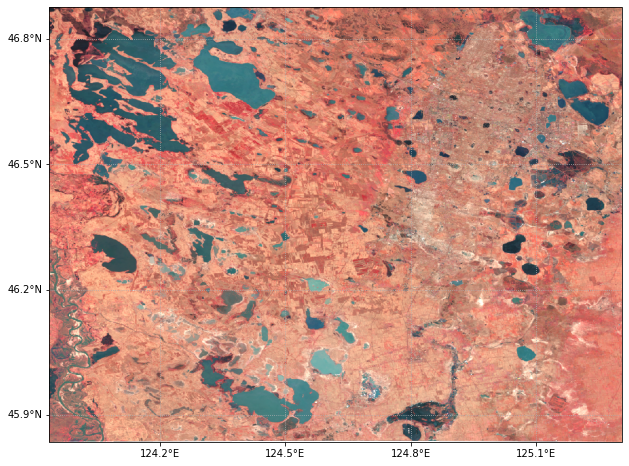

In [14]:
# 合成影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# # 大庆市
re = [125.3055, 45.8362, 123.9355, 46.8762]
# # 天津市
# re = [117.4944, 38.6272, 115.9244, 39.6372]
# # 武汉市
# re = [115.0993, 29.8642, 113.7393, 30.9242]
# # 珠三角
# re = [114.0514, 22.2347, 112.7614, 23.2547]
# 青藏高原
# re = [91.3626, 34.6579, 89.8826, 35.8279]

fig = plt.figure(figsize=(12, 8))
refer_img = ee.Image('users/311605001111/basemap_image/' + region + '_allband')
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
blend = refer_img.visualize(**visParams)

ax = cartoee.get_map(blend, region=re)
cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
# ax.set_title(label = 'Region E', fontsize=28)